In [1]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import pandas as pd
import seaborn as sns

2023-11-27 19:52:56.817359: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sns.set(rc = {'axes.facecolor':'white',
              "axes.edgecolor":'black',    
            "xtick.bottom":True,
            "xtick.top":False,
            "ytick.left":True,
            "ytick.right":False,
            "axes.linewidth":0.2,
            "xtick.major.width":0.2,
            "ytick.major.width":0.2,
            "xtick.minor.width":0.2,
            "ytick.minor.width":0.2,
            "font.size":10,
            "axes.labelsize":10,
            "axes.titlesize":10,
            "xtick.labelsize":10,
            "ytick.labelsize":10,
            "legend.fontsize":10,
            "legend.title_fontsize":10,
            "lines.linewidth":1.0,
            "patch.linewidth":0.2,
            "patch.edgecolor":'black',
            "patch.force_edgecolor":True,
            "xtick.major.size":3,
            "ytick.major.size":3,
            "xtick.minor.size":1,
            "ytick.minor.size":1,
            "xtick.minor.width":0.2,
            "ytick.minor.width":0.2})

In [3]:
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/covid.tfrecords' 
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/healthy.tfrecords' 

File ‘covid.tfrecords’ already there; not retrieving.

File ‘healthy.tfrecords’ already there; not retrieving.



### Ingest the healthy records

In [4]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/healthy.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

2023-11-27 19:53:03.964164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46608 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [5]:
def _parse_function(example_proto):
    feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'covid': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_image(parsed['image_raw'])
    image = tf.image.rot90(image, 3)
    image = tf.reshape(image,[512,512,3])
    #image = tf.image.resize(image, [224, 224])
    image = tf.image.adjust_contrast(image, 50 )
    print(parsed['covid'])
    return image,parsed['covid']

In [6]:
healthy = raw_dataset.map(_parse_function)
healthy

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

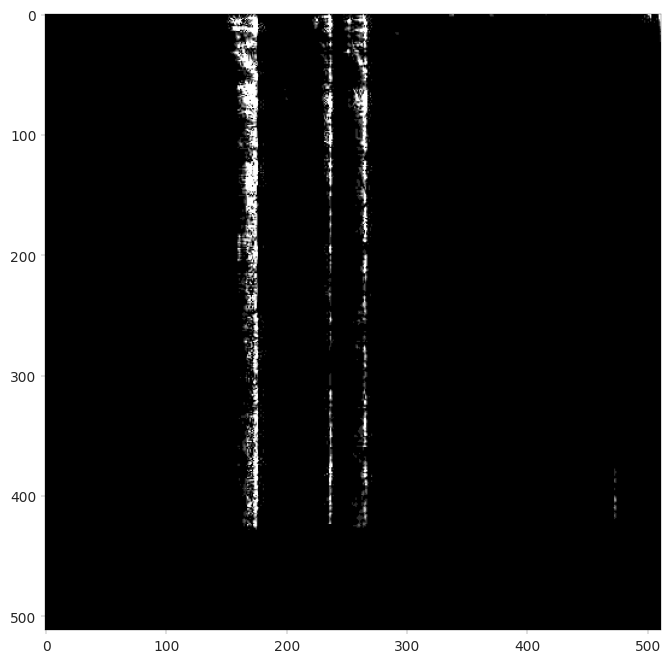

tf.Tensor(0.0, shape=(), dtype=float32)


In [7]:
for image_features in healthy.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(image_raw,cmap='gist_gray')
    plt.grid(False)
    plt.show()
    print(image_features[1])

### Ingest the covid records

In [8]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/covid.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [9]:
covid = raw_dataset.map(_parse_function)

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


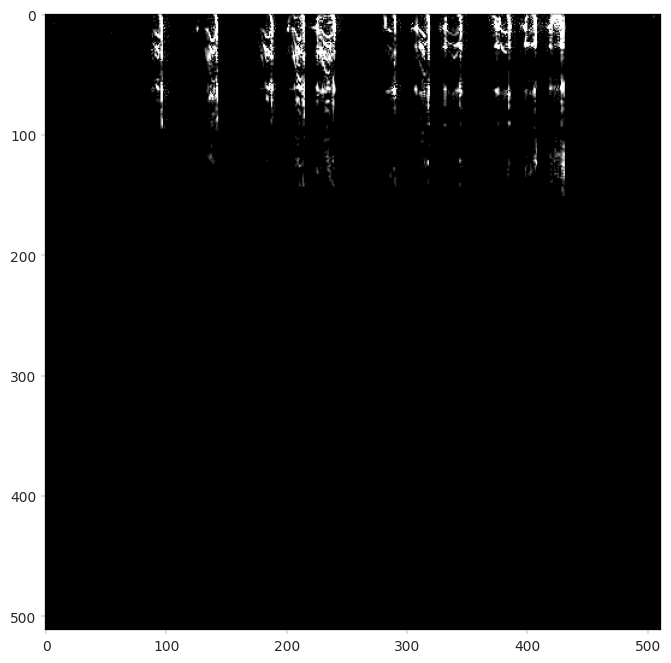

tf.Tensor(1.0, shape=(), dtype=float32)


In [10]:
for image_features in covid.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(image_raw,cmap='gist_gray')
    plt.grid(False)
    plt.show()
    print(image_features[1])

### Concatenate the healthy and covid records into one tensor

In [11]:
data = covid.concatenate(healthy)
# normalization_layer = layers.Rescaling(1./255)
# data = data.map(lambda x, y: (normalization_layer(x), y))
length_dataset = data.reduce(0, lambda x,_: x+1).numpy()

In [12]:
length_dataset

12833

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
data = data.shuffle(10000)
train_raw = data.take(9000)
test_raw = data.skip(9000).take(3833)


In [14]:
labels = []
for ele in test_raw:
    labels.append(ele[1].numpy())
print(f'Number of COVIDs in Test Data: {labels.count(1)}')
print(f'Number of Healthy in Test Data: {labels.count(0)}')
labels = []
for ele in train_raw:
    labels.append(ele[1].numpy())
print(f'Number of COVIDs in Train Data: {labels.count(1)}')
print(f'Number of Healthy in Train Data: {labels.count(0)}')

Number of COVIDs in Test Data: 314
Number of Healthy in Test Data: 3519
Number of COVIDs in Train Data: 800
Number of Healthy in Train Data: 8200


In [15]:
train = train_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(16)
test = test_raw.cache().prefetch(buffer_size=AUTOTUNE).batch(16)

In [16]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [17]:
def get_performance_stats(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    precision = hist.history['precision']
    val_precision = hist.history['val_precision']

    recall = hist.history['recall']
    val_recall = hist.history['val_recall']
    
    auc = hist.history['auc']
    val_auc = hist.history['val_auc']
    
    df = pd.DataFrame({'Accuracy':acc,'Val. Accuracy':val_acc,
                   'Loss':loss,'Val. Loss':val_loss,
                   'Precision':precision, 'Val. Precision':val_precision,
                   'Recall':recall, 'Val. Recall':val_recall,
                   'AUC':auc, 'Val. AUC':val_auc})
    
    df['F1'] = 2*df['Precision']*df['Recall']/(df['Precision'] + df['Recall'])
    
    df['Val. F1'] = 2*df['Val. Precision']*df['Val. Recall']/(df['Val. Precision'] + df['Val. Recall'])
    

    return df

In [18]:
# define the data augmentation sequence

data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomContrast(0.5),
    layers.Rescaling(1./255)
])

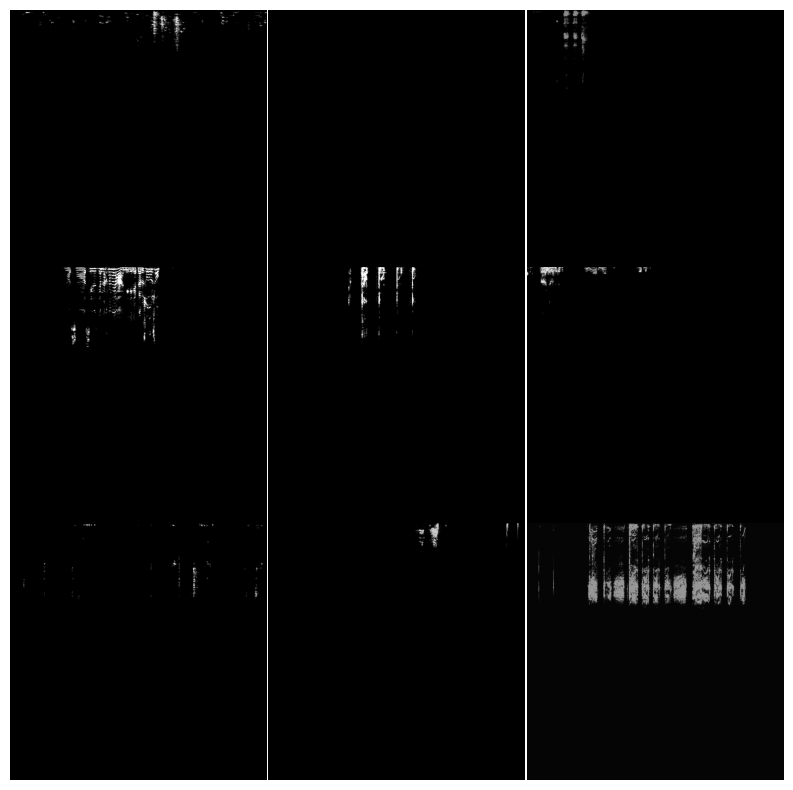

In [19]:
plt.figure(figsize=(10,10))
for i in range(9):
    for image_features in covid.skip(i).take(1):
        image_raw = image_features[0]
        augmented_image = data_augmentation(image_raw)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")
        plt.subplots_adjust(wspace=0, hspace=0)

### Test MobileNetV2

In [45]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

base_model.trainable = False

model = keras.Sequential([
    keras.Input(shape= (512, 512, 3,)),
    #data_augmentation,
    base_model,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])
#model.build(input_shape)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        737344    
                                                                 
 global_average_pooling2d_3  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [47]:
epochs = 20
class_weight = {0: 1.,
                1: 10.}
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight,verbose=2)

Epoch 1/20
563/563 - 37s - loss: 2.1077 - cross entropy: 1.0755 - Brier score: 0.4346 - tp: 153.0000 - fp: 856.0000 - tn: 10842.0000 - fn: 982.0000 - accuracy: 0.8568 - precision: 0.1516 - recall: 0.1348 - auc: 0.5898 - prc: 0.1228 - val_loss: 1.3471 - val_cross entropy: 0.5015 - val_Brier score: 0.1074 - val_tp: 2.0000 - val_fp: 8.0000 - val_tn: 3500.0000 - val_fn: 323.0000 - val_accuracy: 0.9136 - val_precision: 0.2000 - val_recall: 0.0062 - val_auc: 0.6109 - val_prc: 0.1371 - 37s/epoch - 65ms/step
Epoch 2/20
563/563 - 25s - loss: 1.7585 - cross entropy: 0.8435 - Brier score: 0.2513 - tp: 74.0000 - fp: 408.0000 - tn: 7782.0000 - fn: 736.0000 - accuracy: 0.8729 - precision: 0.1535 - recall: 0.0914 - auc: 0.5684 - prc: 0.1152 - val_loss: 1.1404 - val_cross entropy: 0.5909 - val_Brier score: 0.1303 - val_tp: 15.0000 - val_fp: 27.0000 - val_tn: 3481.0000 - val_fn: 310.0000 - val_accuracy: 0.9121 - val_precision: 0.3571 - val_recall: 0.0462 - val_auc: 0.6286 - val_prc: 0.1469 - 25s/epoch 

In [48]:
results_Mobile_Net = get_performance_stats(hist)

Text(0.5, 0, 'Epoch')

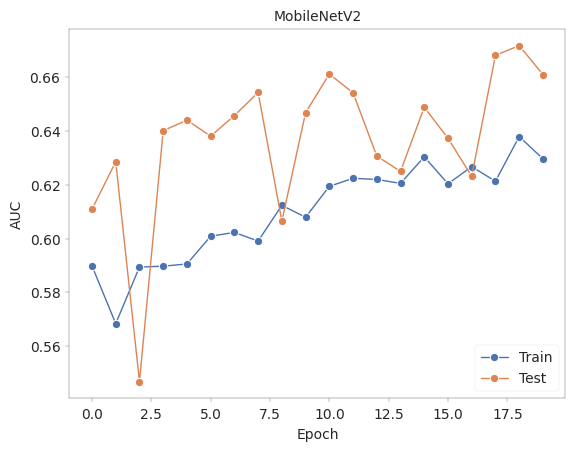

In [49]:
sns.lineplot(data=results_Mobile_Net, x = results_Mobile_Net.index, y = 'AUC',marker='o',label='Train')
sns.lineplot(data=results_Mobile_Net, x = results_Mobile_Net.index, y = 'Val. AUC',marker='o', label = 'Test')
plt.legend(loc = 'lower right')
plt.title('MobileNetV2')
plt.xlabel('Epoch')

In [20]:
# set up a loop to test for a few combos of batch size and learning rate

def grid_search_bs_lr(base_model):
    learning_rate = [0.000001, 0.00001, 0.00005, 0.0001, 0.0005]
    batch_size = [8, 16, 64, 128]

    class_weight = {0: 1.,
                    1: 10.}

    base_model.trainable = False
    Results = pd.DataFrame()
    epochs = 10
    
    for lr in learning_rate:
        for bs in batch_size:
            train = train_raw.cache().prefetch(buffer_size=AUTOTUNE).batch(bs)
            test = test_raw.cache().prefetch(buffer_size=AUTOTUNE).batch(bs)

            model = keras.Sequential([
                keras.Input(shape= (512, 512, 3,)),
                #data_augmentation,
                base_model,
                keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
                keras.layers.GlobalAveragePooling2D(),
                keras.layers.Flatten(),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1)
            ])

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                          loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          metrics=METRICS)

            hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight,verbose=0)
            results = get_performance_stats(hist)
            results['Batch Size'] = bs
            results['Learning Rate'] = lr
            Results = pd.concat([Results, results])
            auc_max = max(results['Val. AUC'])
            print(f'Batch Size: {bs}, Learning Rate: {lr}, Validation AUC: {auc_max}')
    return Results

In [27]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)
Results = grid_search_bs_lr(base_model)

Batch Size: 8, Learning Rate: 1e-06, Validation AUC: 0.5712417364120483


2023-11-25 10:30:09.931613: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14032971354694841386
2023-11-25 10:30:09.931725: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4153379260625409296


Batch Size: 16, Learning Rate: 1e-06, Validation AUC: 0.5674318075180054
Batch Size: 64, Learning Rate: 1e-06, Validation AUC: 0.5589897632598877
Batch Size: 128, Learning Rate: 1e-06, Validation AUC: 0.5482200980186462
Batch Size: 8, Learning Rate: 1e-05, Validation AUC: 0.6067086458206177
Batch Size: 16, Learning Rate: 1e-05, Validation AUC: 0.6009573936462402
Batch Size: 64, Learning Rate: 1e-05, Validation AUC: 0.5711709856987
Batch Size: 128, Learning Rate: 1e-05, Validation AUC: 0.6078839898109436
Batch Size: 8, Learning Rate: 5e-05, Validation AUC: 0.6323902606964111
Batch Size: 16, Learning Rate: 5e-05, Validation AUC: 0.5903645753860474
Batch Size: 64, Learning Rate: 5e-05, Validation AUC: 0.600318968296051


2023-11-25 11:17:06.754242: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14032971354694841386
2023-11-25 11:17:06.754331: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4153379260625409296


Batch Size: 128, Learning Rate: 5e-05, Validation AUC: 0.6275392770767212
Batch Size: 8, Learning Rate: 0.0001, Validation AUC: 0.6207859516143799
Batch Size: 16, Learning Rate: 0.0001, Validation AUC: 0.6265223026275635
Batch Size: 64, Learning Rate: 0.0001, Validation AUC: 0.6184797883033752
Batch Size: 128, Learning Rate: 0.0001, Validation AUC: 0.6195842027664185
Batch Size: 8, Learning Rate: 0.0005, Validation AUC: 0.5
Batch Size: 16, Learning Rate: 0.0005, Validation AUC: 0.5511696934700012
Batch Size: 64, Learning Rate: 0.0005, Validation AUC: 0.5859185457229614
Batch Size: 128, Learning Rate: 0.0005, Validation AUC: 0.5


In [24]:
Results

,Accuracy,Val. Accuracy,Loss,Val. Loss,Precision,Val. Precision,Recall,Val. Recall,AUC,Val. AUC,F1,Val. F1,Batch Size,Learning Rate
0,0.734896,0.914688,2.814538,1.933060,0.094519,0.000000,0.234528,0.000000,0.517875,0.562564,0.134737,NaN,8,0.000001
1,0.682667,0.915210,2.565398,1.852970,0.093565,0.000000,0.297365,0.000000,0.521980,0.572744,0.142342,NaN,8,0.000001
2,0.716000,0.914949,2.507450,1.854021,0.085728,0.000000,0.228356,0.000000,0.500728,0.581681,0.124658,NaN,8,0.000001
3,0.752222,0.915210,2.441740,1.810965,0.078281,0.000000,0.166876,0.000000,0.487573,0.582219,0.106571,NaN,8,0.000001
4,0.808556,0.915210,2.371624,1.774191,0.107627,0.000000,0.159348,0.000000,0.521732,0.581306,0.128477,NaN,8,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.887778,0.914688,1.347262,0.771484,0.160714,0.454545,0.069054,0.015337,0.558702,0.585562,0.096601,0.029674,128,0.000500
6,0.882667,0.914166,1.314893,0.719849,0.148718,0.384615,0.074169,0.015337,0.572175,0.573551,0.098976,0.029499,128,0.000500
7,0.896556,0.913123,1.298893,0.684002,0.150235,0.315789,0.040921,0.018405,0.556615,0.566659,0.064322,0.034783,128,0.000500
8,0.894556,0.912079,1.296436,0.731673,0.147679,0.351351,0.044757,0.039877,0.556873,0.594419,0.068695,0.071625,128,0.000500


Text(0.5, 0, 'Epoch')

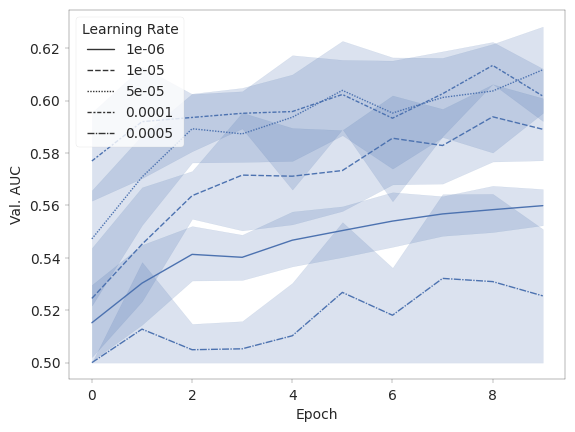

In [28]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Learning Rate')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

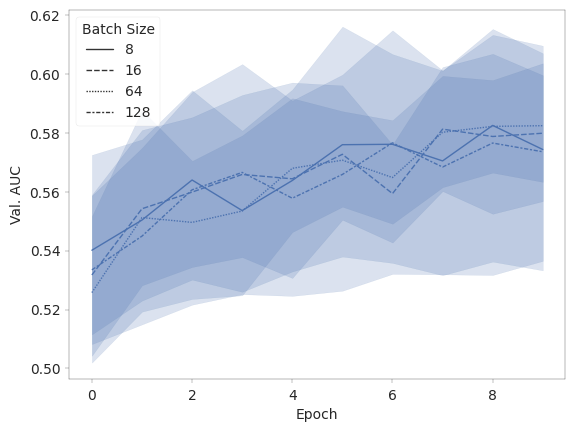

In [29]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Batch Size')
plt.xlabel('Epoch')

### Test VGG19

In [30]:
base_model = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)

Results = grid_search_bs_lr(base_model)

Batch Size: 8, Learning Rate: 1e-06, Validation AUC: 0.5510126352310181
Batch Size: 16, Learning Rate: 1e-06, Validation AUC: 0.5187066197395325


2023-11-25 12:25:29.725021: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11278088973893148408


Batch Size: 64, Learning Rate: 1e-06, Validation AUC: 0.4980514943599701
Batch Size: 128, Learning Rate: 1e-06, Validation AUC: 0.5024711489677429
Batch Size: 8, Learning Rate: 1e-05, Validation AUC: 0.5368001461029053


2023-11-25 13:01:07.912246: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3244958511587834126


Batch Size: 16, Learning Rate: 1e-05, Validation AUC: 0.5


2023-11-25 13:13:07.554532: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3244958511587834126
2023-11-25 13:13:07.554644: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1171209970482038742


Batch Size: 64, Learning Rate: 1e-05, Validation AUC: 0.5
Batch Size: 128, Learning Rate: 1e-05, Validation AUC: 0.5515861511230469
Batch Size: 8, Learning Rate: 5e-05, Validation AUC: 0.5770407319068909
Batch Size: 16, Learning Rate: 5e-05, Validation AUC: 0.5774555206298828


2023-11-25 14:01:20.280304: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 969116821262244330
2023-11-25 14:01:20.280439: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1171209970482038742
2023-11-25 14:01:50.437798: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18057168456824200599
2023-11-25 14:01:50.437955: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11278088973893148408


Batch Size: 64, Learning Rate: 5e-05, Validation AUC: 0.5008653402328491
Batch Size: 128, Learning Rate: 5e-05, Validation AUC: 0.5307273864746094


2023-11-25 14:24:51.483262: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3244958511587834126
2023-11-25 14:24:51.483352: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 969116821262244330
2023-11-25 14:24:51.483366: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1171209970482038742
2023-11-25 14:25:23.198316: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11278088973893148408


Batch Size: 8, Learning Rate: 0.0001, Validation AUC: 0.5463575124740601
Batch Size: 16, Learning Rate: 0.0001, Validation AUC: 0.5682502388954163


2023-11-25 14:49:30.141229: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 969116821262244330
2023-11-25 14:49:30.141300: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1171209970482038742
2023-11-25 14:50:00.112940: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18057168456824200599
2023-11-25 14:50:00.113062: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11278088973893148408


Batch Size: 64, Learning Rate: 0.0001, Validation AUC: 0.5786405801773071
Batch Size: 128, Learning Rate: 0.0001, Validation AUC: 0.5329473614692688


2023-11-25 15:13:20.592280: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11278088973893148408


Batch Size: 8, Learning Rate: 0.0005, Validation AUC: 0.5407004952430725
Batch Size: 16, Learning Rate: 0.0005, Validation AUC: 0.5


2023-11-25 15:38:27.126528: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 18057168456824200599
2023-11-25 15:38:27.126659: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11278088973893148408


Batch Size: 64, Learning Rate: 0.0005, Validation AUC: 0.5


2023-11-25 15:49:30.866488: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3244958511587834126
2023-11-25 15:49:30.866563: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1171209970482038742


Batch Size: 128, Learning Rate: 0.0005, Validation AUC: 0.5515691637992859


<Axes: ylabel='Val. AUC'>

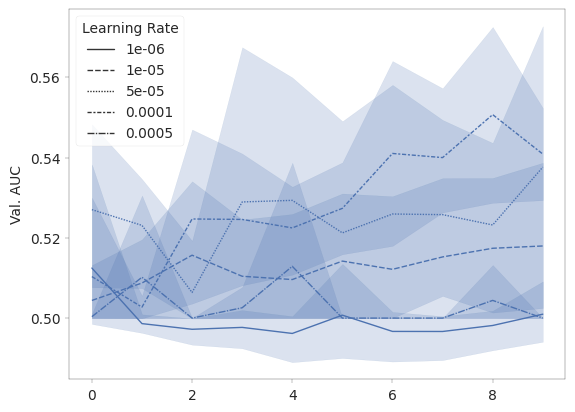

In [31]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Learning Rate')

<Axes: ylabel='Val. AUC'>

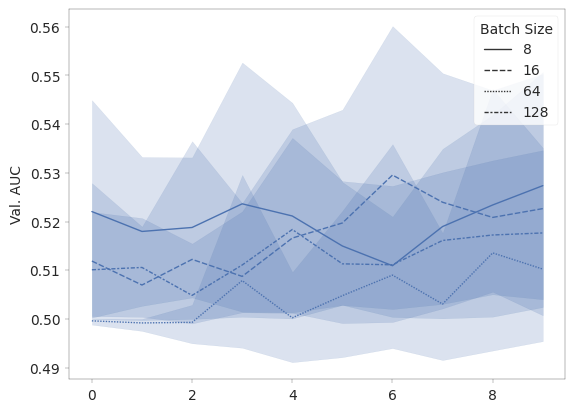

In [32]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Batch Size')

In [40]:
inputs = keras.Input(shape=[512, 512, 3])
# train = train_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(16)
# test = test_raw.cache().prefetch(buffer_size=AUTOTUNE).batch(16)
base_model = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)

base_model.trainable = False

model = keras.Sequential([
    keras.Input(shape= (512, 512, 3,)),
    #data_augmentation,
    base_model,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])
#model.build(input_shape)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        294976    
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [42]:
epochs = 20
class_weight = {0: 1.,
                1: 10.}
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight,verbose=2)

Epoch 1/20
563/563 - 72s - loss: 2.1120 - cross entropy: 1.3727 - Brier score: 0.4768 - tp: 135.0000 - fp: 1193.0000 - tn: 10505.0000 - fn: 1000.0000 - accuracy: 0.8291 - precision: 0.1017 - recall: 0.1189 - auc: 0.5404 - prc: 0.0978 - val_loss: 1.2868 - val_cross entropy: 0.6415 - val_Brier score: 0.1366 - val_tp: 35.0000 - val_fp: 137.0000 - val_tn: 3371.0000 - val_fn: 290.0000 - val_accuracy: 0.8886 - val_precision: 0.2035 - val_recall: 0.1077 - val_auc: 0.6330 - val_prc: 0.1461 - 72s/epoch - 127ms/step
Epoch 2/20
563/563 - 69s - loss: 1.7140 - cross entropy: 0.9200 - Brier score: 0.3111 - tp: 106.0000 - fp: 587.0000 - tn: 7603.0000 - fn: 704.0000 - accuracy: 0.8566 - precision: 0.1530 - recall: 0.1309 - auc: 0.5994 - prc: 0.1270 - val_loss: 1.0926 - val_cross entropy: 0.6624 - val_Brier score: 0.1593 - val_tp: 41.0000 - val_fp: 145.0000 - val_tn: 3363.0000 - val_fn: 284.0000 - val_accuracy: 0.8881 - val_precision: 0.2204 - val_recall: 0.1262 - val_auc: 0.6375 - val_prc: 0.1592 - 69

In [43]:
results_VGG19 = get_performance_stats(hist)

Text(0.5, 0, 'Epoch')

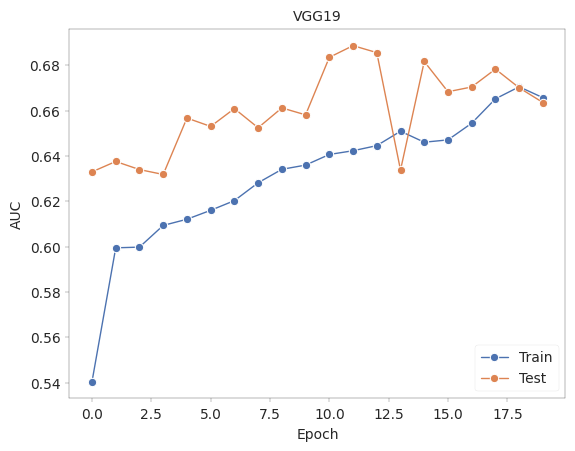

In [44]:
sns.lineplot(data=results_VGG19, x = results_VGG19.index, y = 'AUC',marker='o',label='Train')
sns.lineplot(data=results_VGG19, x = results_VGG19.index, y = 'Val. AUC',marker='o', label = 'Test')
plt.legend(loc = 'lower right')
plt.title('VGG19')
plt.xlabel('Epoch')

### Test Efficient Net B2

In [44]:
import contextlib

In [45]:
@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)

In [24]:
with options({"layout_optimizer": False}):
    base_model = keras.applications.efficientnet.EfficientNetB2(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=2,
        classifier_activation='softmax',
    )
    Results = grid_search_bs_lr(base_model)

2023-11-26 13:03:50.169505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-26 13:03:51.109001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-26 13:03:51.852820: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5f31264e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 13:03:51.852879: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-26 13:03:51.933408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 13:03:52.503519: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

Batch Size: 8, Learning Rate: 1e-06, Validation AUC: 0.5795820355415344
Batch Size: 16, Learning Rate: 1e-06, Validation AUC: 0.5897193551063538
Batch Size: 64, Learning Rate: 1e-06, Validation AUC: 0.5639898180961609
Batch Size: 128, Learning Rate: 1e-06, Validation AUC: 0.5709599256515503
Batch Size: 8, Learning Rate: 1e-05, Validation AUC: 0.6654382944107056
Batch Size: 16, Learning Rate: 1e-05, Validation AUC: 0.6299866437911987
Batch Size: 64, Learning Rate: 1e-05, Validation AUC: 0.6153761148452759
Batch Size: 128, Learning Rate: 1e-05, Validation AUC: 0.6065388321876526
Batch Size: 8, Learning Rate: 5e-05, Validation AUC: 0.6623432636260986
Batch Size: 16, Learning Rate: 5e-05, Validation AUC: 0.6478102803230286
Batch Size: 64, Learning Rate: 5e-05, Validation AUC: 0.619746208190918
Batch Size: 128, Learning Rate: 5e-05, Validation AUC: 0.6329425573348999
Batch Size: 8, Learning Rate: 0.0001, Validation AUC: 0.6054840087890625
Batch Size: 16, Learning Rate: 0.0001, Validation AU

<Axes: ylabel='Val. AUC'>

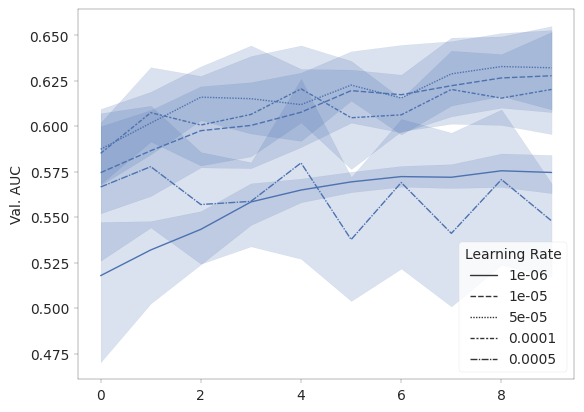

In [25]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Learning Rate')

<Axes: ylabel='Val. AUC'>

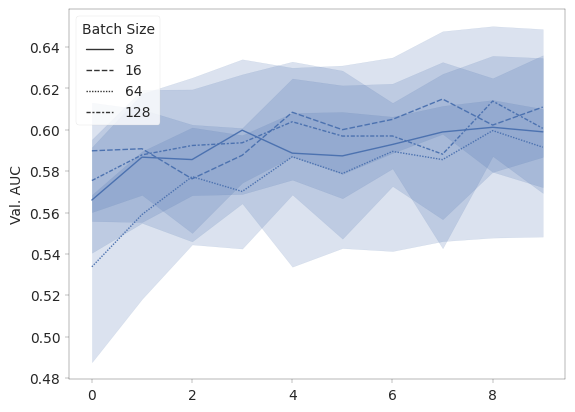

In [26]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Batch Size')

In [30]:
inputs = keras.Input(shape=[512, 512, 3])

#train = train_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(16)
# test = test_raw.cache().prefetch(buffer_size=AUTOTUNE).batch(16)

base_model = keras.applications.efficientnet.EfficientNetB2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
)


base_model.trainable = False

model = keras.Sequential([
    keras.Input(shape= (512, 512, 3,)),
    # data_augmentation,
    base_model,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [31]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        811072    
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_21 (Flatten)        (None, 64)                0         
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)               

In [32]:
epochs = 20
class_weight = {0: 1.,
                1: 10.}
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight,verbose=2)

Epoch 1/20
563/563 - 63s - loss: 2.2589 - cross entropy: 1.1104 - Brier score: 0.2839 - tp: 114.0000 - fp: 820.0000 - tn: 11043.0000 - fn: 1055.0000 - accuracy: 0.8561 - precision: 0.1221 - recall: 0.0975 - auc: 0.5300 - prc: 0.1018 - val_loss: 1.5045 - val_cross entropy: 0.8389 - val_Brier score: 0.1694 - val_tp: 6.0000 - val_fp: 10.0000 - val_tn: 3496.0000 - val_fn: 321.0000 - val_accuracy: 0.9136 - val_precision: 0.3750 - val_recall: 0.0183 - val_auc: 0.5893 - val_prc: 0.1339 - 63s/epoch - 112ms/step
Epoch 2/20
563/563 - 55s - loss: 1.9496 - cross entropy: 0.9030 - Brier score: 0.3259 - tp: 86.0000 - fp: 551.0000 - tn: 7678.0000 - fn: 685.0000 - accuracy: 0.8627 - precision: 0.1350 - recall: 0.1115 - auc: 0.5750 - prc: 0.1103 - val_loss: 1.2668 - val_cross entropy: 0.9655 - val_Brier score: 0.1727 - val_tp: 7.0000 - val_fp: 14.0000 - val_tn: 3492.0000 - val_fn: 320.0000 - val_accuracy: 0.9129 - val_precision: 0.3333 - val_recall: 0.0214 - val_auc: 0.5711 - val_prc: 0.1341 - 55s/epoc

In [33]:
results_ENB2 = get_performance_stats(hist)

Text(0.5, 0, 'Epoch')

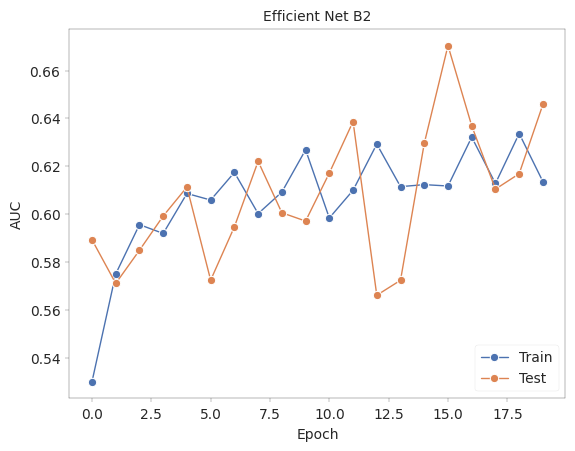

In [34]:
sns.lineplot(data=results_ENB2, x = results_ENB2.index, y = 'AUC',marker='o',label='Train')
sns.lineplot(data=results_ENB2, x = results_ENB2.index, y = 'Val. AUC',marker='o', label = 'Test')
plt.legend(loc = 'lower right')
plt.title('Efficient Net B2')
plt.xlabel('Epoch')

### Test Inception V3

In [21]:
base_model = keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
)
Results = grid_search_bs_lr(base_model)

2023-11-26 16:39:08.447603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-26 16:39:10.450764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-26 16:39:10.473846: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2da50afb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 16:39:10.473876: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-26 16:39:10.550898: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 16:39:11.042523: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

Batch Size: 8, Learning Rate: 1e-06, Validation AUC: 0.5838009119033813
Batch Size: 16, Learning Rate: 1e-06, Validation AUC: 0.6114487648010254
Batch Size: 64, Learning Rate: 1e-06, Validation AUC: 0.5510538816452026
Batch Size: 128, Learning Rate: 1e-06, Validation AUC: 0.5472226738929749
Batch Size: 8, Learning Rate: 1e-05, Validation AUC: 0.6561425924301147
Batch Size: 16, Learning Rate: 1e-05, Validation AUC: 0.6626541614532471
Batch Size: 64, Learning Rate: 1e-05, Validation AUC: 0.6087931990623474
Batch Size: 128, Learning Rate: 1e-05, Validation AUC: 0.5922471284866333
Batch Size: 8, Learning Rate: 5e-05, Validation AUC: 0.6507958769798279
Batch Size: 16, Learning Rate: 5e-05, Validation AUC: 0.617877721786499
Batch Size: 64, Learning Rate: 5e-05, Validation AUC: 0.6819339990615845
Batch Size: 128, Learning Rate: 5e-05, Validation AUC: 0.6139521598815918
Batch Size: 8, Learning Rate: 0.0001, Validation AUC: 0.6061790585517883
Batch Size: 16, Learning Rate: 0.0001, Validation AU

<Axes: ylabel='Val. AUC'>

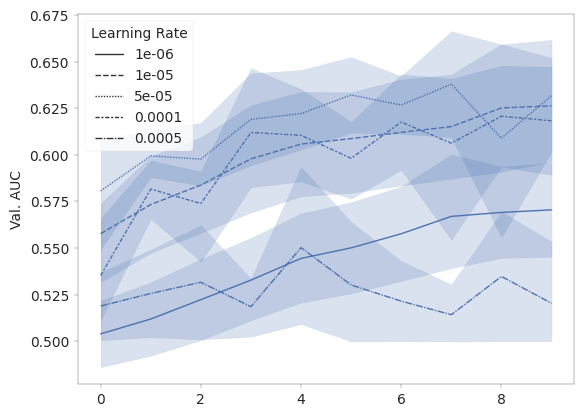

In [22]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Learning Rate')

<Axes: ylabel='Val. AUC'>

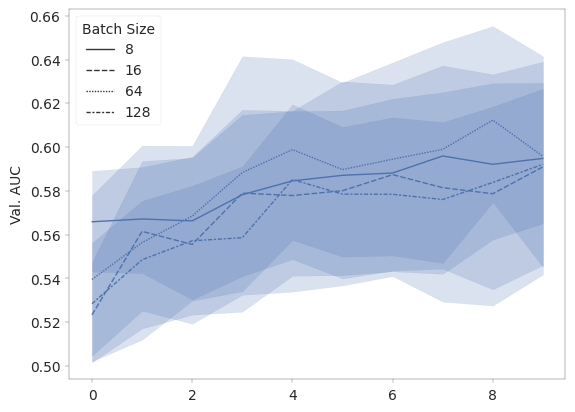

In [23]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Batch Size')

In [24]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)


base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [25]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 conv2d_208 (Conv2D)         (None, None, None, 64)    1179712   
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 flatten_20 (Flatten)        (None, 64)                0         
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)               

In [26]:
epochs = 20
class_weight = {0: 1.,
                1: 10.}
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight,verbose=2)

Epoch 1/20
563/563 - 48s - loss: 2.5398 - cross entropy: 1.4706 - Brier score: 1.7377 - tp: 87.0000 - fp: 789.0000 - tn: 10921.0000 - fn: 1036.0000 - accuracy: 0.8578 - precision: 0.0993 - recall: 0.0775 - auc: 0.5339 - prc: 0.0961 - val_loss: 1.6045 - val_cross entropy: 0.7196 - val_Brier score: 0.1194 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 3497.0000 - val_fn: 335.0000 - val_accuracy: 0.9123 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5946 - val_prc: 0.1165 - 48s/epoch - 85ms/step
Epoch 2/20
563/563 - 29s - loss: 2.0514 - cross entropy: 0.8673 - Brier score: 0.2371 - tp: 33.0000 - fp: 247.0000 - tn: 7957.0000 - fn: 763.0000 - accuracy: 0.8878 - precision: 0.1179 - recall: 0.0415 - auc: 0.5619 - prc: 0.1065 - val_loss: 1.2613 - val_cross entropy: 1.0698 - val_Brier score: 0.5933 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 3496.0000 - val_fn: 334.0000 - val_accuracy: 0.9123 - val_precision: 0.3333 - val_recall: 0.0030 - val_auc: 0.5521 - val_prc: 0.1139 - 

In [27]:
results_Inception = get_performance_stats(hist)

Text(0.5, 0, 'Epoch')

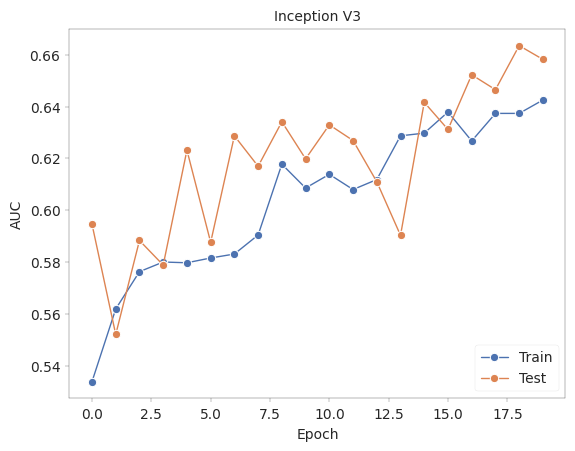

In [28]:
sns.lineplot(data=results_Inception, x = results_Inception.index, y = 'AUC',marker='o',label='Train')
sns.lineplot(data=results_Inception, x = results_Inception.index, y = 'Val. AUC',marker='o', label = 'Test')
plt.legend(loc = 'lower right')
plt.title('Inception V3')
plt.xlabel('Epoch')

### Test Efficient Net B7

In [46]:
with options({"layout_optimizer": False}):
    base_model = keras.applications.efficientnet.EfficientNetB7(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=2,
        classifier_activation='softmax',
    )
    Results = grid_search_bs_lr(base_model)

2023-11-26 19:59:50.557398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-26 19:59:51.759243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-26 19:59:52.653528: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6000fa63b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 19:59:52.653577: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-26 19:59:52.758803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 19:59:53.477550: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

Batch Size: 8, Learning Rate: 1e-06, Validation AUC: 0.6160506010055542
Batch Size: 16, Learning Rate: 1e-06, Validation AUC: 0.5992214679718018
Batch Size: 64, Learning Rate: 1e-06, Validation AUC: 0.5769742727279663
Batch Size: 128, Learning Rate: 1e-06, Validation AUC: 0.5514550805091858
Batch Size: 8, Learning Rate: 1e-05, Validation AUC: 0.6293473243713379
Batch Size: 16, Learning Rate: 1e-05, Validation AUC: 0.6194841861724854
Batch Size: 64, Learning Rate: 1e-05, Validation AUC: 0.5740509033203125
Batch Size: 128, Learning Rate: 1e-05, Validation AUC: 0.6300191283226013
Batch Size: 8, Learning Rate: 5e-05, Validation AUC: 0.5489435791969299
Batch Size: 16, Learning Rate: 5e-05, Validation AUC: 0.6331130862236023
Batch Size: 64, Learning Rate: 5e-05, Validation AUC: 0.6362862586975098
Batch Size: 128, Learning Rate: 5e-05, Validation AUC: 0.6525137424468994
Batch Size: 8, Learning Rate: 0.0001, Validation AUC: 0.6129931807518005
Batch Size: 16, Learning Rate: 0.0001, Validation A

<Axes: ylabel='Val. AUC'>

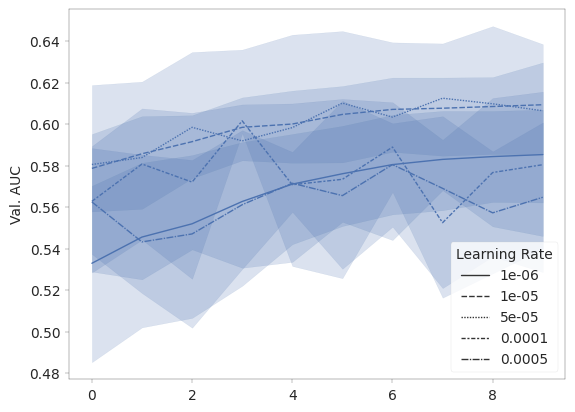

In [47]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Learning Rate')

<Axes: ylabel='Val. AUC'>

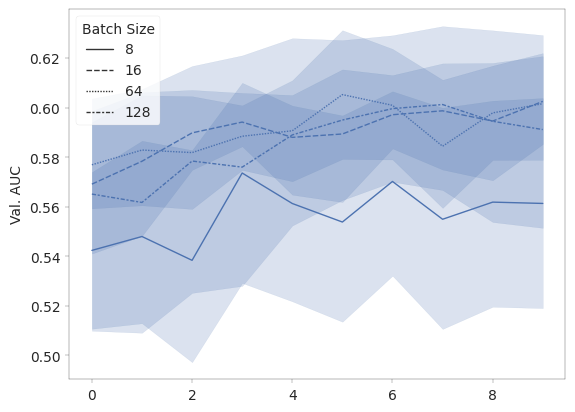

In [48]:
sns.lineplot(data=Results, x=Results.index, y='Val. AUC',style='Batch Size')

In [21]:
inputs = keras.Input(shape=[512, 512, 3])

base_model = keras.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
)


base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    1474624   
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [23]:
epochs = 20
class_weight = {0: 1.,
                1: 10.}
hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight,verbose=2)

Epoch 1/20


2023-11-27 13:00:37.661107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-27 13:00:45.569614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-27 13:00:46.766440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-27 13:00:47.883178: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2e0ca16420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 13:00:47.883226: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-27 13:00:47.962043: I tensorflow/compiler/mlir/tensorflow/uti

563/563 - 242s - loss: 2.4704 - cross entropy: 1.0056 - Brier score: 0.2821 - tp: 90.0000 - fp: 753.0000 - tn: 7437.0000 - fn: 720.0000 - accuracy: 0.8363 - precision: 0.1068 - recall: 0.1111 - auc: 0.5466 - prc: 0.1010 - val_loss: 1.8091 - val_cross entropy: 0.7348 - val_Brier score: 0.1867 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3520.0000 - val_fn: 303.0000 - val_accuracy: 0.9191 - val_precision: 0.3000 - val_recall: 0.0098 - val_auc: 0.5987 - val_prc: 0.1218 - 242s/epoch - 429ms/step
Epoch 2/20
563/563 - 206s - loss: 2.3764 - cross entropy: 0.9036 - Brier score: 0.2633 - tp: 94.0000 - fp: 611.0000 - tn: 7579.0000 - fn: 716.0000 - accuracy: 0.8526 - precision: 0.1333 - recall: 0.1160 - auc: 0.5671 - prc: 0.1153 - val_loss: 1.7254 - val_cross entropy: 0.7821 - val_Brier score: 0.1845 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 3524.0000 - val_fn: 306.0000 - val_accuracy: 0.9194 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6004 - val_prc: 0.1244 - 206s/epoc

In [24]:
results_ENB7 = get_performance_stats(hist)

Text(0.5, 0, 'Epoch')

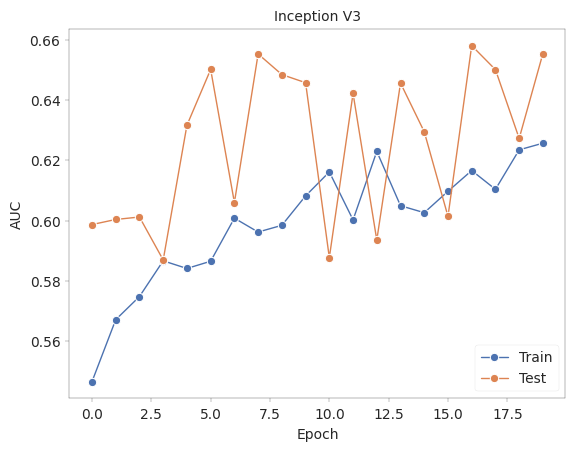

In [25]:
sns.lineplot(data=results_ENB7, x = results_ENB7.index, y = 'AUC',marker='o',label='Train')
sns.lineplot(data=results_ENB7, x = results_ENB7.index, y = 'Val. AUC',marker='o', label = 'Test')
plt.legend(loc = 'lower right')
plt.title('Inception V3')
plt.xlabel('Epoch')

### Compare Results between using data augmentation and no data augmentation

In [27]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomContrast(0.5),
keras.layers.RandomBrightness([-0.1,0.1]),
    layers.Rescaling(1./255)
])

class_weight = {0: 1.,
                1: 10.}

In [28]:
def augment_vs_none(base_model, lr):
    # train with no data augmentation
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=METRICS)
    
    hist=model.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)
    
    # train with data augmentation
    model_aug = keras.Sequential([
        data_augmentation,
        base_model,
        keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer='L2'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1)
    ])

    model_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=METRICS)
    
    hist_aug=model_aug.fit(train,epochs=epochs,validation_data=test,class_weight=class_weight)
    
    # plot results
    results_aug = get_performance_stats(hist_aug)
    results = get_performance_stats(hist)
    
    sns.lineplot(data=results_aug, x = results_aug.index, y = 'Val. AUC',marker='o',label='With Augmentation')
    sns.lineplot(data=results, x = results.index, y = 'Val. AUC',marker='o', label = 'Without Augmentation')
    plt.legend(loc = 'lower right')
    plt.xlabel('Epoch')
    plt.show()
    
    return results_aug, results

Epoch 1/30
563/563 [==============================] - 29s 47ms/step - loss: 2.1946 - cross entropy: 1.1560 - Brier score: 0.3781 - tp: 174.0000 - fp: 1062.0000 - tn: 13941.0000 - fn: 1279.0000 - accuracy: 0.8577 - precision: 0.1408 - recall: 0.1198 - auc: 0.5630 - prc: 0.1109 - val_loss: 1.3695 - val_cross entropy: 0.7726 - val_Brier score: 0.1730 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5965 - val_prc: 0.1287
Epoch 2/30
563/563 [==============================] - 26s 45ms/step - loss: 1.8370 - cross entropy: 0.7958 - Brier score: 0.2542 - tp: 45.0000 - fp: 246.0000 - tn: 7959.0000 - fn: 750.0000 - accuracy: 0.8893 - precision: 0.1546 - recall: 0.0566 - auc: 0.5650 - prc: 0.1132 - val_loss: 1.2349 - val_cross entropy: 0.5928 - val_Brier score: 0.1753 - val_tp: 41.0000 - val_fp: 182.0000 - val_tn: 3327.0000 - val_fn: 283.0000 - val_accuracy: 0.8787 - val_precis

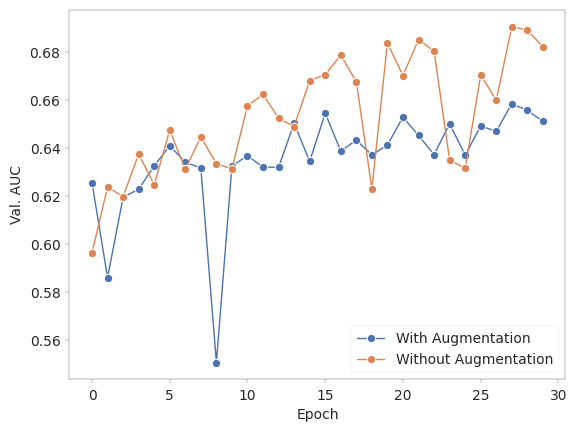

In [34]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

lr = 5e-5
epochs = 30 
results_aug_MNV2, results_MNV2 = augment_vs_none(base_model, lr)

Epoch 1/30
563/563 [==============================] - 72s 125ms/step - loss: 2.1574 - cross entropy: 1.5369 - Brier score: 0.7430 - tp: 222.0000 - fp: 1585.0000 - tn: 10129.0000 - fn: 897.0000 - accuracy: 0.8066 - precision: 0.1229 - recall: 0.1984 - auc: 0.5674 - prc: 0.1071 - val_loss: 1.3439 - val_cross entropy: 0.8213 - val_Brier score: 0.1729 - val_tp: 74.0000 - val_fp: 381.0000 - val_tn: 3128.0000 - val_fn: 250.0000 - val_accuracy: 0.8354 - val_precision: 0.1626 - val_recall: 0.2284 - val_auc: 0.6089 - val_prc: 0.1284
Epoch 2/30
  1/563 [..............................] - ETA: 54s - loss: 2.6772 - cross entropy: 1.4867 - Brier score: 0.2846 - tp: 1.0000 - fp: 1.0000 - tn: 11.0000 - fn: 3.0000 - accuracy: 0.7500 - precision: 0.5000 - recall: 0.2500 - auc: 0.6250 - prc: 0.4769

2023-11-27 21:45:58.868524: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2664231396948182995
2023-11-27 21:45:58.868810: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4481933083442096120


563/563 [==============================] - 70s 125ms/step - loss: 1.7286 - cross entropy: 1.0650 - Brier score: 0.3489 - tp: 110.0000 - fp: 659.0000 - tn: 7546.0000 - fn: 685.0000 - accuracy: 0.8507 - precision: 0.1430 - recall: 0.1384 - auc: 0.5745 - prc: 0.1202 - val_loss: 1.2646 - val_cross entropy: 1.3506 - val_Brier score: 0.2563 - val_tp: 135.0000 - val_fp: 854.0000 - val_tn: 2655.0000 - val_fn: 189.0000 - val_accuracy: 0.7279 - val_precision: 0.1365 - val_recall: 0.4167 - val_auc: 0.6241 - val_prc: 0.1281
Epoch 3/30
563/563 [==============================] - 70s 125ms/step - loss: 1.5814 - cross entropy: 1.0445 - Brier score: 0.3545 - tp: 134.0000 - fp: 649.0000 - tn: 7556.0000 - fn: 661.0000 - accuracy: 0.8544 - precision: 0.1711 - recall: 0.1686 - auc: 0.5923 - prc: 0.1280 - val_loss: 0.9417 - val_cross entropy: 0.8002 - val_Brier score: 0.2814 - val_tp: 21.0000 - val_fp: 85.0000 - val_tn: 3424.0000 - val_fn: 303.0000 - val_accuracy: 0.8988 - val_precision: 0.1981 - val_recall

2023-11-27 22:20:48.636231: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14394631232120173057


563/563 [==============================] - 74s 128ms/step - loss: 1.6611 - cross entropy: 0.9654 - Brier score: 0.4717 - tp: 75.0000 - fp: 408.0000 - tn: 11306.0000 - fn: 1044.0000 - accuracy: 0.8869 - precision: 0.1553 - recall: 0.0670 - auc: 0.5609 - prc: 0.1115 - val_loss: 0.8281 - val_cross entropy: 1.3039 - val_Brier score: 0.1047 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0845
Epoch 2/30
563/563 [==============================] - 72s 128ms/step - loss: 1.3715 - cross entropy: 0.9768 - Brier score: 0.1090 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 8205.0000 - fn: 795.0000 - accuracy: 0.9117 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5099 - prc: 0.0903 - val_loss: 0.7849 - val_cross entropy: 0.8317 - val_Brier score: 0.0884 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val

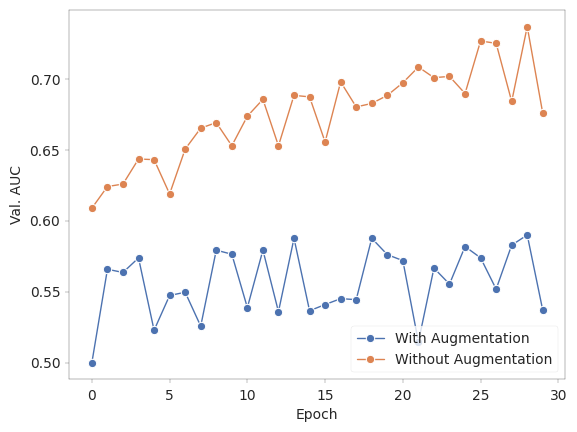

In [35]:
base_model = keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

lr = 0.0001
epochs = 30 
results_aug_VGG19, results_VGG19 = augment_vs_none(base_model, lr)

Epoch 1/30


2023-11-27 22:56:08.788290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


563/563 [==============================] - 64s 102ms/step - loss: 2.2185 - cross entropy: 0.9973 - Brier score: 0.2055 - tp: 48.0000 - fp: 442.0000 - tn: 11272.0000 - fn: 1071.0000 - accuracy: 0.8821 - precision: 0.0980 - recall: 0.0429 - auc: 0.5347 - prc: 0.0971 - val_loss: 1.4746 - val_cross entropy: 0.6063 - val_Brier score: 0.1235 - val_tp: 21.0000 - val_fp: 110.0000 - val_tn: 3399.0000 - val_fn: 303.0000 - val_accuracy: 0.8923 - val_precision: 0.1603 - val_recall: 0.0648 - val_auc: 0.6079 - val_prc: 0.1232
Epoch 2/30
563/563 [==============================] - 56s 99ms/step - loss: 1.8781 - cross entropy: 0.9240 - Brier score: 0.2481 - tp: 67.0000 - fp: 441.0000 - tn: 7764.0000 - fn: 728.0000 - accuracy: 0.8701 - precision: 0.1319 - recall: 0.0843 - auc: 0.5599 - prc: 0.1085 - val_loss: 1.1146 - val_cross entropy: 1.0723 - val_Brier score: 0.2831 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 3505.0000 - val_fn: 323.0000 - val_accuracy: 0.9147 - val_precision: 0.2000 - val_recall: 0.

2023-11-27 23:24:39.769747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


563/563 [==============================] - 68s 105ms/step - loss: 2.0274 - cross entropy: 0.9246 - Brier score: 0.2085 - tp: 56.0000 - fp: 334.0000 - tn: 11380.0000 - fn: 1063.0000 - accuracy: 0.8911 - precision: 0.1436 - recall: 0.0500 - auc: 0.5374 - prc: 0.1031 - val_loss: 1.1777 - val_cross entropy: 1.3039 - val_Brier score: 0.0954 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0845
Epoch 2/30
563/563 [==============================] - 58s 102ms/step - loss: 1.6379 - cross entropy: 0.9971 - Brier score: 0.1209 - tp: 9.0000 - fp: 74.0000 - tn: 8131.0000 - fn: 786.0000 - accuracy: 0.9044 - precision: 0.1084 - recall: 0.0113 - auc: 0.5025 - prc: 0.0917 - val_loss: 0.9762 - val_cross entropy: 1.3039 - val_Brier score: 0.0908 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 0.0

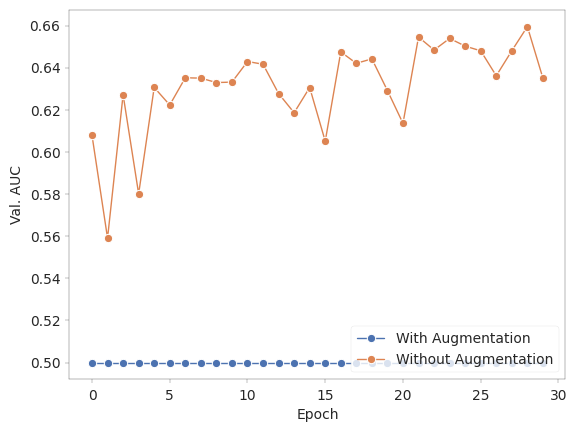

In [36]:
base_model = keras.applications.efficientnet.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

lr = 5e-5
epochs = 30 
results_aug_ENB2, results_ENB2 = augment_vs_none(base_model, lr)

Epoch 1/30
563/563 [==============================] - 36s 56ms/step - loss: 2.4323 - cross entropy: 1.4810 - Brier score: 0.8373 - tp: 109.0000 - fp: 873.0000 - tn: 10841.0000 - fn: 1010.0000 - accuracy: 0.8533 - precision: 0.1110 - recall: 0.0974 - auc: 0.5244 - prc: 0.0954 - val_loss: 1.5978 - val_cross entropy: 0.5305 - val_Brier score: 0.0941 - val_tp: 2.0000 - val_fp: 8.0000 - val_tn: 3501.0000 - val_fn: 322.0000 - val_accuracy: 0.9139 - val_precision: 0.2000 - val_recall: 0.0062 - val_auc: 0.6104 - val_prc: 0.1162
Epoch 2/30
563/563 [==============================] - 30s 54ms/step - loss: 2.0071 - cross entropy: 0.8307 - Brier score: 0.2613 - tp: 39.0000 - fp: 256.0000 - tn: 7949.0000 - fn: 756.0000 - accuracy: 0.8876 - precision: 0.1322 - recall: 0.0491 - auc: 0.5747 - prc: 0.1098 - val_loss: 1.2463 - val_cross entropy: 0.9472 - val_Brier score: 0.4053 - val_tp: 3.0000 - val_fp: 11.0000 - val_tn: 3498.0000 - val_fn: 321.0000 - val_accuracy: 0.9134 - val_precision: 0.2143 - val_r

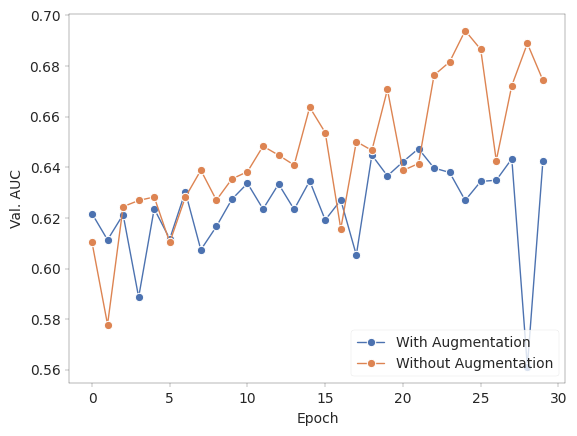

In [37]:
base_model = keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

lr = 5e-5
epochs = 30 
results_aug_INV3, results_INV3 = augment_vs_none(base_model, lr)

Epoch 1/30


2023-11-28 00:25:29.863302: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


563/563 [==============================] - 230s 382ms/step - loss: 2.4565 - cross entropy: 0.9162 - Brier score: 0.2732 - tp: 157.0000 - fp: 1037.0000 - tn: 10677.0000 - fn: 962.0000 - accuracy: 0.8442 - precision: 0.1315 - recall: 0.1403 - auc: 0.5639 - prc: 0.1135 - val_loss: 1.8051 - val_cross entropy: 0.7774 - val_Brier score: 0.1800 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5824 - val_prc: 0.1142
Epoch 2/30
563/563 [==============================] - 210s 373ms/step - loss: 2.3482 - cross entropy: 0.9033 - Brier score: 0.2823 - tp: 66.0000 - fp: 471.0000 - tn: 7734.0000 - fn: 729.0000 - accuracy: 0.8667 - precision: 0.1229 - recall: 0.0830 - auc: 0.5586 - prc: 0.1070 - val_loss: 1.7294 - val_cross entropy: 0.7146 - val_Brier score: 0.2081 - val_tp: 11.0000 - val_fp: 33.0000 - val_tn: 3476.0000 - val_fn: 313.0000 - val_accuracy: 0.9097 - val_precision: 0.25

2023-11-28 02:10:38.969720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


563/563 [==============================] - 234s 383ms/step - loss: 2.4191 - cross entropy: 1.1082 - Brier score: 0.2384 - tp: 185.0000 - fp: 1296.0000 - tn: 10418.0000 - fn: 934.0000 - accuracy: 0.8262 - precision: 0.1249 - recall: 0.1653 - auc: 0.5446 - prc: 0.1111 - val_loss: 1.7854 - val_cross entropy: 0.2948 - val_Brier score: 0.0780 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5008 - val_prc: 0.0889
Epoch 2/30
563/563 [==============================] - 211s 376ms/step - loss: 2.2528 - cross entropy: 0.9030 - Brier score: 0.1401 - tp: 6.0000 - fp: 67.0000 - tn: 8138.0000 - fn: 789.0000 - accuracy: 0.9049 - precision: 0.0822 - recall: 0.0075 - auc: 0.5049 - prc: 0.0895 - val_loss: 1.6520 - val_cross entropy: 0.2990 - val_Brier score: 0.0785 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3509.0000 - val_fn: 324.0000 - val_accuracy: 0.9155 - val_precision: 

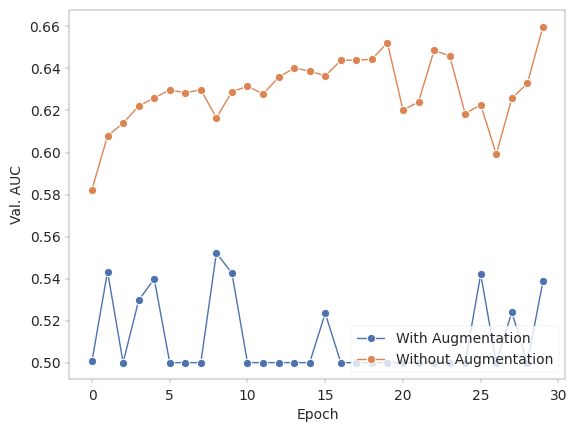

In [38]:
base_model = keras.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

lr = 0.00001
epochs = 30 
results_aug_ENB7, results_ENB7 = augment_vs_none(base_model, lr)

In [39]:
results_MNV2['Model'] = 'MobileNetV2'
results_MNV2= results_MNV2.reset_index()
results_ENB2['Model'] = 'EfficientNetB2'
results_ENB2 = results_ENB2.reset_index()
results_INV3['Model'] = 'InceptionV3'
results_INV3 = results_INV3.reset_index()
results_ENB7['Model'] ='EfficientNetB7'
results_ENB7= results_ENB7.reset_index()
results_VGG19['Model'] = 'VGG19'
results_VGG19 = results_VGG19.reset_index()

results =pd.concat([results_MNV2,results_ENB2, results_INV3, results_ENB7, results_VGG19])


In [40]:
results_max = results.groupby(by='Model').max()
results_max = results_max.reset_index()
results['index'] = results['index'] + 1

Text(0, 0.5, 'Validation AUC')

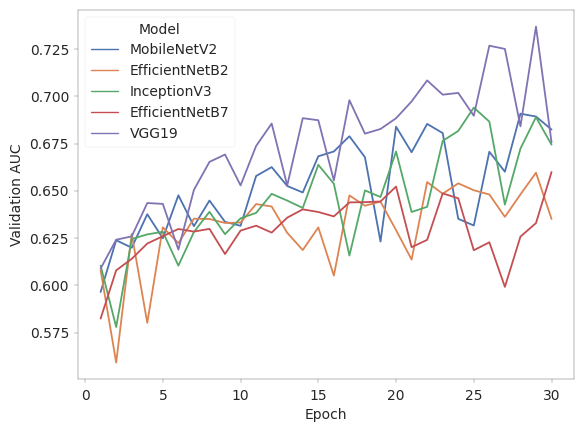

In [41]:
sns.lineplot(data=results, x='index', y='Val. AUC',hue='Model',linewidth=1.3)
plt.xlabel('Epoch')
plt.ylabel('Validation AUC')

In [42]:
AUC = results_max[['Model','AUC','Val. AUC']]

In [43]:
AUC = pd.melt(AUC,id_vars='Model')
AUC = AUC.replace({'AUC':'Train','Val. AUC':'Validation'})
AUC = AUC.rename({'variable':'Train/Validation'},axis=1)
AUC

,Model,Train/Validation,value
0,EfficientNetB2,Train,0.632261
1,EfficientNetB7,Train,0.645686
2,InceptionV3,Train,0.685159
3,MobileNetV2,Train,0.665454
4,VGG19,Train,0.705835
5,EfficientNetB2,Validation,0.659552
6,EfficientNetB7,Validation,0.659923
7,InceptionV3,Validation,0.694013
8,MobileNetV2,Validation,0.690781
9,VGG19,Validation,0.736853


<Figure size 1000x600 with 0 Axes>

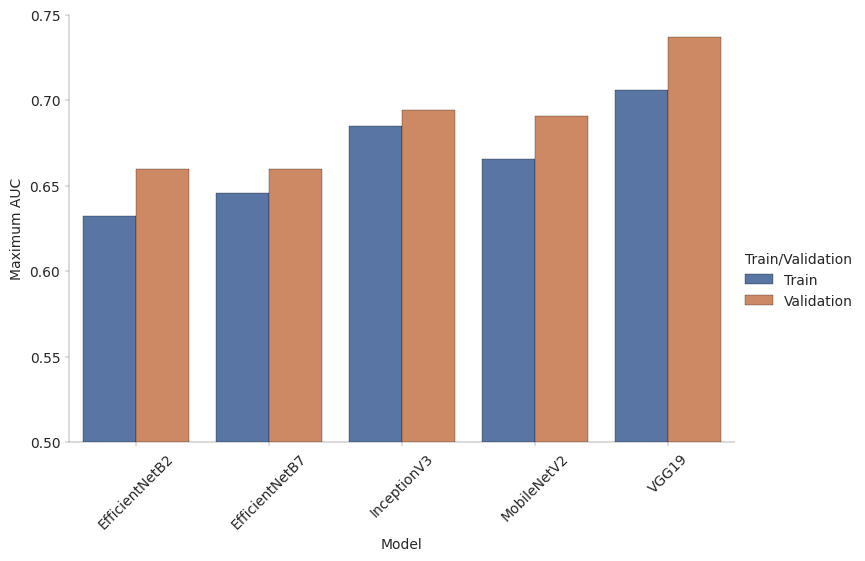

In [47]:
plt.figure(figsize=(5,3),dpi=200)
sns.catplot(data=AUC,x='Model',y='value',hue='Train/Validation',kind='bar',aspect=1.5)
plt.xticks(rotation=45)
plt.ylabel('Maximum AUC')
plt.ylim([0.5,0.75])
plt.show()